In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import set_matplotlib_formats
from scipy.optimize import fmin
from scipy.stats import chi2, norm

# Set plot details
set_matplotlib_formats('png', 'pdf')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
sns.set_style('darkgrid')
sns.set_context('notebook')

**1 a)**

$f(x_i, \theta_0, \theta_1) = \theta_0 + \theta_1 x_i$

$\mathcal{X}^2 = \sum_{i=1}^{N}\frac{\left(y_i - f(x_i, \theta_0, \theta_1)\right)^2}{\sigma^{2}_{y_i}}$


**1 b, c)**

Optimization terminated successfully.
         Current function value: 82.794508
         Iterations: 36
         Function evaluations: 71


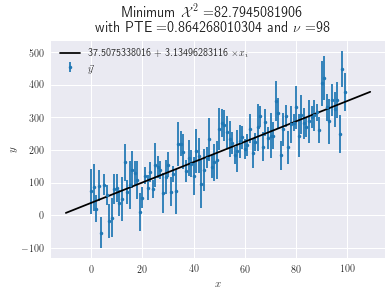

In [2]:
def read_data(fname='hw6.dat'):
    df = pd.read_csv(fname, skiprows=1,
                     delim_whitespace=True,
                     names=['x', 'y', 'y_err'])
    return np.array(df['x']), np.array(df['y']), np.array(df['y_err'])


def get_line_model(theta, x):
    return theta[0] + theta[1]*x


def get_chi2(theta, model_func, x, y, y_err):
    model = model_func(theta, x)
    return np.sum(((y - model)**2)/(y_err**2))


def minimize_chi2(guess_theta, model_func, x, y, y_err):
    xopt = fmin(get_chi2, guess_theta,
                args=(model_func,
                      x, y, y_err))

    return xopt, get_chi2(xopt, model_func, x, y, y_err)


def do_problem_1bc(fname='hw6.dat', guess_theta=[37.5, 3.14]):
    x, y, y_err = read_data(fname)
    best_theta, min_chi2 = minimize_chi2(guess_theta,
                                         get_line_model,
                                         x, y, y_err)

    # Set a good range to plot the model line
    x_range = np.max(x) - np.min(x)
    x_low = np.min(x) - 0.1*x_range
    x_high = np.max(x) + 0.1*x_range

    model_x = np.linspace(x_low, x_high, 1000)
    model_y = get_line_model(best_theta, model_x)
    
    # Plot details
    model_label = str(best_theta[0]) + ' $+$ '
    model_label += str(best_theta[1]) + r' $\times x_i$'
    title_label = r'Minimum $\mathcal{X}^2 =$' + str(min_chi2)
    title_label += '\n'+ ' with PTE $=$'
    title_label += str(chi2.sf(min_chi2, len(y)-2)) 
    title_label += r' and $\nu=$'
    title_label += str(int(len(x)-2))
    
    plt.errorbar(x, y, y_err, fmt='.', label=r'$\vec{y}$')
    plt.plot(model_x, model_y, '-k', label=model_label)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.suptitle(title_label, y=1.0)
    plt.legend()
    plt.show()
    return best_theta, [x, y, y_err], min_chi2

best_theta, data, min_chi2 = do_problem_1bc()
x, y, y_err = data

Given the $\nu=98$, we are roughly within the expected uncertainty of the $\mathcal{X}^2$ estimator (about $\sim 1.1 \sigma$ away). Therefore we can consider this a good fit to the data under the assumptions of our model PDF (Gaussianity, independence, etc.)

$\frac{\partial \ln{\mathcal{L}}}{\partial \theta_0} = -\sum_{i} \frac{\left(\theta_0 + \theta_1 x_i - y\right)}{\sigma_i^2}$

$\frac{\partial \ln{\mathcal{L}}}{\partial \theta_1} = -\sum_{i} \frac{x_i\left(\theta_0 + \theta_1 x_i - y\right)}{\sigma_i^2}$

$\frac{\partial^2 \ln{\mathcal{L}}}{\partial \theta_0 \partial \theta_1} = \frac{\partial^2 \ln{\mathcal{L}}}{\partial \theta_1 \partial \theta_0}  = -\sum_{i} \frac{x_i}{\sigma_i^2}$

$\frac{\partial^2 \ln{\mathcal{L}}}{\partial \theta_0^2 } = -\sum_{i} \frac{1}{\sigma_i^2}$

$\frac{\partial^2 \ln{\mathcal{L}}}{\partial \theta_1^2 } = -\sum_{i} \frac{x_i^2}{\sigma_i^2}$

$\mathcal{F}_{ij} = -\frac{\partial^2 \ln{\mathcal{L}}}{\partial \theta_i \partial \theta_j}$

$\implies \mathcal{F} = \begin{pmatrix}\sum_{i}\frac{1}{\sigma_i^2} & \sum_{i}\frac{x_i}{\sigma_i^2}\\\sum_{i}\frac{x_i}{\sigma_i^2} & \sum_{i}\frac{x_i^2}{\sigma_i^2}\end{pmatrix}$

$\implies\lvert \mathcal{F} \rvert = \left(\sum_i\frac{1}{\sigma_i^2}\right)\left(\sum_i\frac{x_i^2}{\sigma_i^2}\right) - \left(\sum_i\frac{x_i}{\sigma_i^2}\right)^2$

$\implies \mathcal{F}^{-1} = \frac{1}{\left(\sum_i\frac{1}{\sigma_i^2}\right)\left(\sum_i\frac{x_i^2}{\sigma_i^2}\right) - \left(\sum_i\frac{x_i}{\sigma_i^2}\right)^2} \begin{pmatrix}\sum_{i}\frac{x_i^2}{\sigma_i^2} & -\sum_{i}\frac{x_i}{\sigma_i^2}\\ -\sum_{i}\frac{x_i}{\sigma_i^2} & \sum_{i}\frac{1}{\sigma_i^2}\end{pmatrix}$

In [3]:
def get_fisher_matrix(theta, x, y, y_err):
    a = np.sum(1/(y_err**2.0))
    b = np.sum(x/(y_err**2.0))
    c = b
    d = np.sum(((x**2.0)/(y_err**2.0)))
    return np.asmatrix([[a, b], [c, d]])

def get_covariance_matrix(fisher_matrix):
    a = fisher_matrix[0, 0]
    b = fisher_matrix[0, 1]
    c = fisher_matrix[1, 0]
    d = fisher_matrix[1, 1]
    determinant = (a*d - b*c)
    new_a = d/determinant
    new_b = -c/determinant
    new_c = -b/determinant
    new_d = a/determinant
    return np.asmatrix([[new_a, new_b], [new_c, new_d]])

def do_problem_2cde(theta, x, y, y_err):
    fisher_matrix = get_fisher_matrix(theta, x, y, y_err)
    covariance_matrix = get_covariance_matrix(fisher_matrix)
    correlation_denom = np.sqrt(covariance_matrix[0, 0]*covariance_matrix[1, 1])
    correlation_coeff = covariance_matrix[0, 1]/correlation_denom
    print('Fisher Matrix Estimator at Maximum Likelihood: ', fisher_matrix)
    print('Covariance Matrix at Maximum Likelihood: ', covariance_matrix)
    print('Uncertainty in Intercept is: ', np.sqrt(covariance_matrix[0,0]))
    print('Uncertainty in Slope is: ', np.sqrt(covariance_matrix[1, 1]))
    print('Correlation Coefficient is: ', correlation_coeff)
    return fisher_matrix, covariance_matrix

fisher_matrix, covariance_matrix = do_problem_2cde(best_theta, x, y, y_err)

Fisher Matrix Estimator at Maximum Likelihood:  [[  5.56802594e-02   2.70339927e+00]
 [  2.70339927e+00   1.73776178e+02]]
Covariance Matrix at Maximum Likelihood:  [[  7.33996214e+01  -1.14186240e+00]
 [ -1.14186240e+00   2.35182406e-02]]
Uncertainty in Intercept is:  8.56735790183
Uncertainty in Slope is:  0.153356579923
Correlation Coefficient is:  -0.869089386297


This makes sense since given the data, an increased slope would require a much lower y-intercept and vice-versa.

In [4]:
def get_chi2_grid(best_theta, covariance_matrix, x, y, y_err):
    # Evaluate the chi2 over a grid of theta values
    theta_0_uncertainty = np.sqrt(covariance_matrix[0, 0])
    theta_1_uncertainty = np.sqrt(covariance_matrix[1, 1])
    grid_x = np.linspace(-8.0*theta_0_uncertainty,
                         8.0*theta_0_uncertainty, 1000)
    grid_x += best_theta[0]
    grid_y = np.linspace(-8.0*theta_1_uncertainty,
                    8.0*theta_1_uncertainty, 1000)
    grid_y += best_theta[1]
    X, Y = np.meshgrid(grid_x, grid_y)
    chi2_grid = np.empty_like(X)
    for i in range(0, len(grid_x)):
        for j in range(0, len(grid_y)):
            temp_theta = [X[i, j], Y[i, j]]
            chi2_grid[i, j] = get_chi2(temp_theta,
                                       get_line_model, x, y, y_err)
    return chi2_grid, X, Y, theta_0_uncertainty, theta_1_uncertainty

chi2_grid, X, Y, theta_0_uncertainty, theta_1_uncertainty = get_chi2_grid(
    best_theta, covariance_matrix, x, y, y_err)

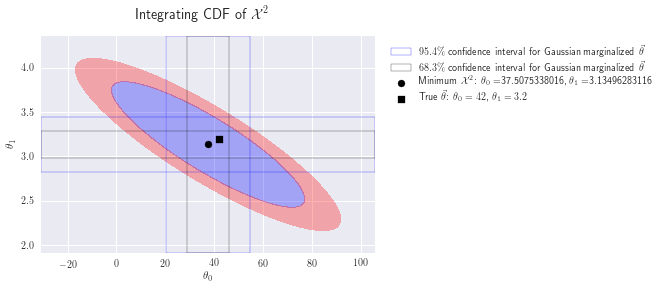

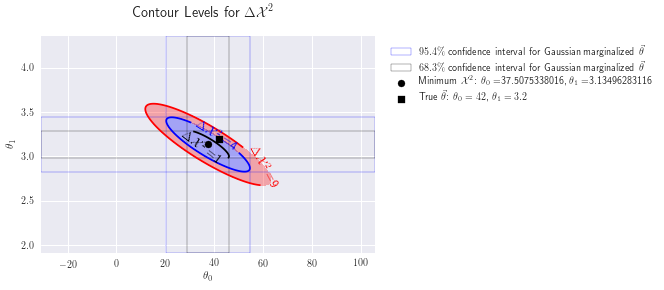

In [5]:
def do_problem_2fg(chi2_grid, X, Y, min_chi2,
                   best_theta, theta_0_uncertainty, theta_1_uncertainty):
    interval_0 = [0, chi2.ppf(0.683, 98)]
    interval_1 = [0,  chi2.ppf(0.955, 98)]

    label_strings = [r'$0\%$', r'$0\%$', r'$68.3\%$', r'$95.5\%$']
    min_label = r'Minimum $\mathcal{X}^2$: '
    min_label += r'$\theta_0 = $' + str(best_theta[0])
    min_label += r', $\theta_1 = $' + str(best_theta[1])
    true_label = r'True $\vec{\theta}$: '
    true_label += r'$\theta_0 = 42$'
    true_label += r', $\theta_1 = 3.2$'

    interval_theta_0_683 = norm.interval(0.683,
                                         loc=best_theta[0],
                                         scale=theta_0_uncertainty)
    interval_theta_0_954 = norm.interval(0.954,
                                         loc=best_theta[0],
                                         scale=theta_0_uncertainty)
    interval_theta_1_683 = norm.interval(0.683,
                                         loc=best_theta[1],
                                         scale=theta_1_uncertainty)
    interval_theta_1_954 = norm.interval(0.954,
                                         loc=best_theta[1],
                                         scale=theta_1_uncertainty)

    plt.axvspan(interval_theta_0_954[0],
               interval_theta_0_954[1],
               color='b',fill=False,
               label=r'$95.4\%$ confidence interval for Gaussian marginalized $\vec{\theta}$')
    plt.axhspan(interval_theta_1_954[0],
               interval_theta_1_954[1],
               color='b',
               fill=False)



    plt.axvspan(interval_theta_0_683[0],
               interval_theta_0_683[1],
               color='k', fill=False,
               label=r'$68.3\%$ confidence interval for Gaussian marginalized $\vec{\theta}$')
    plt.axhspan(interval_theta_1_683[0],
               interval_theta_1_683[1],
               color='k', fill=False)



    CS = plt.contourf(X, Y, chi2_grid,
                      levels=[0.0,interval_0[1], interval_1[1]],
                      alpha=0.3,
                      colors=['b', 'r'])


    plt.scatter(best_theta[0], best_theta[1],
                color='k', marker='o',
               label=min_label)
    plt.scatter(42.0, 3.2, color='k', marker='s',
               label=true_label)

    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')
    plt.suptitle(r'Integrating CDF of $\mathcal{X}^2$')
    plt.legend(bbox_to_anchor=[1.02, 1.0])
    plt.show()

do_problem_2fg(chi2_grid, X, Y, min_chi2,
               best_theta, theta_0_uncertainty,
               theta_1_uncertainty)

def do_problem_2fg_2(chi2_grid, X, Y, min_chi2,
                     best_theta, theta_0_uncertainty, theta_1_uncertainty):
    del_1 = min_chi2 + 1.0
    del_2 = min_chi2 + 4.0
    del_3 = min_chi2 + 9.0

    label_strings = [r'$\Delta \mathcal{X}^2 = $' + str(i**2)
                     for i in [1, 2, 3]]
    min_label = r'Minimum $\mathcal{X}^2$: '
    min_label += r'$\theta_0 = $' + str(best_theta[0])
    min_label += r', $\theta_1 = $' + str(best_theta[1])
    true_label = r'True $\vec{\theta}$: '
    true_label += r'$\theta_0 = 42$'
    true_label += r', $\theta_1 = 3.2$'

    interval_theta_0_683 = norm.interval(0.683,
                                         loc=best_theta[0],
                                         scale=theta_0_uncertainty)
    interval_theta_0_954 = norm.interval(0.954,
                                         loc=best_theta[0],
                                         scale=theta_0_uncertainty)
    interval_theta_1_683 = norm.interval(0.683,
                                         loc=best_theta[1],
                                         scale=theta_1_uncertainty)
    interval_theta_1_954 = norm.interval(0.954,
                                         loc=best_theta[1],
                                         scale=theta_1_uncertainty)

    plt.axvspan(interval_theta_0_954[0],
               interval_theta_0_954[1],
               color='b',fill=False,
               label=r'$95.4\%$ confidence interval for Gaussian marginalized $\vec{\theta}$')
    plt.axhspan(interval_theta_1_954[0],
               interval_theta_1_954[1],
               color='b',
               fill=False)



    plt.axvspan(interval_theta_0_683[0],
               interval_theta_0_683[1],
               color='k', fill=False,
               label=r'$68.3\%$ confidence interval for Gaussian marginalized $\vec{\theta}$')
    plt.axhspan(interval_theta_1_683[0],
               interval_theta_1_683[1],
               color='k', fill=False)


    CS = plt.contour(X, Y, chi2_grid,
                     levels=[del_1, del_2, del_3],
                     colors=['k', 'b', 'r'])
    plt.contourf(X, Y, chi2_grid,
                levels=[0.0, del_2, del_3],
                alpha=0.3,
                colors=['b', 'r'])

    fmt = {}
    for l, s in zip(CS.levels, label_strings):
        fmt[l] = s
    plt.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=13)

    plt.scatter(best_theta[0], best_theta[1],
                color='k', marker='o',
               label=min_label)
    plt.scatter(42.0, 3.2, color='k', marker='s',
               label=true_label)

    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')
    plt.suptitle(r'Contour Levels for $\Delta \mathcal{X}^2$')
    plt.legend(bbox_to_anchor=[1.02, 1.0])
    plt.show()
    
do_problem_2fg_2(chi2_grid, X, Y, min_chi2,
                 best_theta, theta_0_uncertainty,
                 theta_1_uncertainty)

In the first plot I found the inverse CDf of 68.3% and 95.5% for a $\mathcal{X}^2$ distribution with $\nu=98$ and shaded them blue and red respectively. The "true" value lies within the rectangle described by the marginalized uncertainties of the parameters, but if you look at the second plot it does not lie within the $\Delta \mathcal{X}^2 = 1$ ellipse. The marginal uncertainties describe the limits of the ellipse for $\Delta\mathcal{X}^2 = 1$ perfectly. Given the underlying assumptions of the $\mathcal{X}^2$ distribution, this is self-consistent. The "true" parameter values lie on the boundary of the 2$\sigma$ ellipse for the marginalized uncertainties. 